# USING DATA MINING FOR BANK DIRECT MARKETING 

## Introduction

Our dataset comes from the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the [article](CRISP-DM-BANK.pdf) accompanying the dataset for more information on the data and features.

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Answer 1:

  The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE, SVMSMOTE
from sklearn.base import BaseEstimator, TransformerMixin

from collections import Counter
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier 

from sklearn.metrics import confusion_matrix, precision_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc

import warnings
warnings.simplefilter("ignore")

In [7]:
# This is the full set
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

# this is the 10% set for quick analysis
#df = pd.read_csv('data/bank-additional.csv', sep = ';')

### Problem 3 : Understanding the Features


- From the README accompanying the dataset we understand the feature descriptions as explained below.
- There is already a level of data cleaning done, thus there are no NULL values.
- The missing values are already co-erced to an `unknown` categroy for categorical columns.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed', 'services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```


In [9]:
df.head().to_markdown()

'|    |   age | job       | marital   | education   | default   | housing   | loan   | contact   | month   | day_of_week   |   duration |   campaign |   pdays |   previous | poutcome    |   emp.var.rate |   cons.price.idx |   cons.conf.idx |   euribor3m |   nr.employed | y   |\n|---:|------:|:----------|:----------|:------------|:----------|:----------|:-------|:----------|:--------|:--------------|-----------:|-----------:|--------:|-----------:|:------------|---------------:|-----------------:|----------------:|------------:|--------------:|:----|\n|  0 |    56 | housemaid | married   | basic.4y    | no        | no        | no     | telephone | may     | mon           |        261 |          1 |     999 |          0 | nonexistent |            1.1 |           93.994 |           -36.4 |       4.857 |          5191 | no  |\n|  1 |    57 | services  | married   | high.school | unknown   | no        | no     | telephone | may     | mon           |        149 |          1 |     999 |      

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### Business Objective

Our primary business objective is to enhance the efficiency of directed marketing campaigns aimed at increasing long-term deposit subscriptions. This involves using data mining techniques to reduce the number of contacts required while maintaining a similar number of successful subscriptions. Essentially, we want to identify the most promising leads to target, thereby optimizing resource allocation and improving campaign effectiveness.

### Problem 5: Engineering Features

Now that we understand our business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

### Create X, y - Independent and Target Variables

In [15]:
X = df.drop(columns = ['y'], axis = 1)

In [16]:
# Create the target variable of type Boolean based on 'yes' 'no' values in the dataset.
y = df['y'].map({'yes': 1, 'no': 0})

In [17]:
# Review the balance of Positive and Negative classes
y.value_counts(normalize=True)

y
0    0.887346
1    0.112654
Name: proportion, dtype: float64

### Problem 6: Train/Test Split

With our data prepared, we split it into a train and test set.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=y, # Since we have an imbalanced class for the target we want to ensure proportionate representation of classes
    random_state=42,
)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

The AUC plots the False Positive Rate (FPR) versus the True Positive Rate (TPR) and allows identifying how good is the class discrimination: the higher the better, with the ideal model having a value of 1.0.

A random baseline classifier produces a 0.5 Area under Curve (AUC), and the **ideal** AUC value is 1.0.

We should attempt to beat this metric in all our models and strive to reach the ideal.

In [22]:
dummy_cls = DummyClassifier(strategy='uniform')
dummy_cls.fit(X_train, y_train)

DummyClassifier(strategy='uniform')

In [23]:
y_preds = dummy_cls.predict(X_test)

In [24]:
print(f'Precision Score is: {precision_score(y_test, dummy_cls.predict(X_test)):.2%}')

Precision Score is: 11.79%


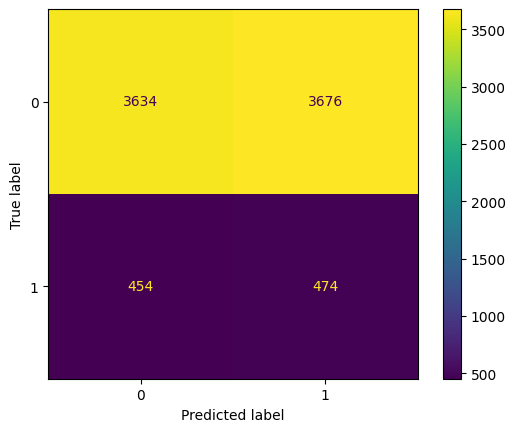

In [25]:
baseline_cm_display = ConfusionMatrixDisplay.from_estimator(dummy_cls, X_test, y_test)

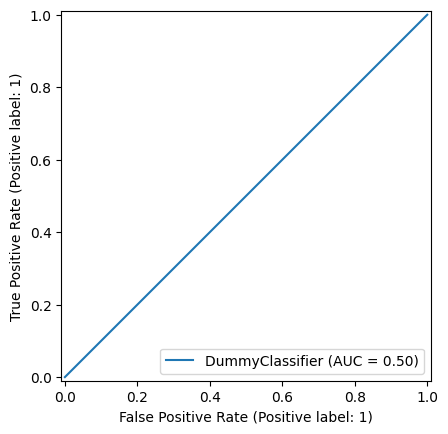

In [26]:
RocCurveDisplay.from_estimator(dummy_cls, X_test, y_test)

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [28]:
# Define numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

In [29]:
# Create a ColumnTransformer for scaling and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
    ]
)

In [30]:
simple_cls = LogisticRegression()

In [31]:
simple_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', simple_cls),
    ]
)


In [32]:
simple_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('classifier', LogisticRegression())])

In [33]:
y_preds = simple_pipeline.predict(X_test)

### Problem 9: Score the Model

What is the accuracy of your model?

In [35]:
print(f'Precision Score is: {precision_score(y_test, simple_pipeline.predict(X_test)):.2%}')

Precision Score is: 70.95%


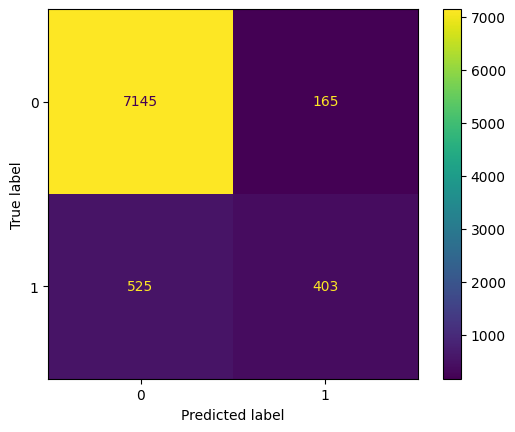

In [130]:
simple_cm_display = ConfusionMatrixDisplay.from_estimator(simple_pipeline, X_test, y_test)
#simple_cm_display.plot()
plt.savefig('images/simple_model_CM.png')  # You can specify the file format here


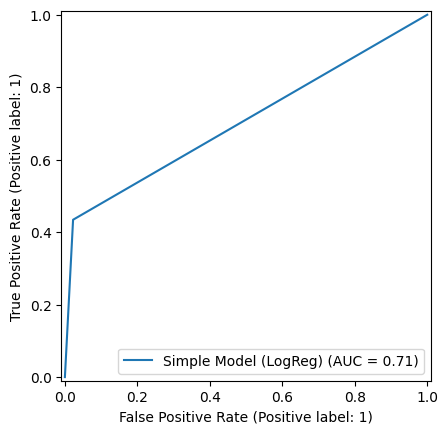

In [37]:
RocCurveDisplay.from_predictions(y_test, y_preds, pos_label=1, name = 'Simple Model (LogReg)')

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|  M1   |  0.x       |  xx.xx%        |   yy.yy%.     |

In [39]:
import time

def fit_and_evaluate_pipeline(classifier, X_train, y_train, X_test, y_test):

    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier),
        ]
    )
    
    start_time = time.time()  # Start time for training
    pipeline.fit(X_train, y_train)  # Fit the pipeline
    train_time = time.time() - start_time  # Calculate training time

    # Predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Calculate roc_auc scores
    train_fpr, train_tpr, _ = roc_curve(y_train, y_train_pred)
    train_roc_auc = auc(train_fpr, train_tpr)
    
    test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred)
    test_roc_auc = auc(test_fpr, test_tpr)
    
    return train_time, train_roc_auc, test_roc_auc


In [40]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC()
}

# DataFrame to store results
models_results = pd.DataFrame(columns=['Train Time', 'Training Results', 'Testing Results'])

# Loop through models
for model_name, model in models.items():
    train_time, train_result, test_result = fit_and_evaluate_pipeline(model, X_train, y_train, X_test, y_test)
    
    # Store results in DataFrame
    models_results.loc[model_name] = [train_time, train_result, test_result]

# Format the DataFrame for better readability
models_results['Train Time'] = models_results['Train Time'].round(2)
models_results['Training Results'] = models_results['Training Results'].round(2)
models_results['Testing Results'] = models_results['Testing Results'].round(2)


In [67]:
# Display the results
models_results

,Train Time,Training Results,Testing Results
Logistic Regression,0.21,0.69,0.71
KNN,0.10,0.77,0.70
Decision Tree,0.38,1.00,0.75
SVM,15.71,0.72,0.70


**Observations** 

1. It looks like the **Decision Tree** model is while overfitted (training Result = 100%) seems to have the best performance for the test set.
2. **SVC** had the largest fit-time as was to be expected. All other models training time was insignificant as being less the 1 second.
3. **KNN**, **LogReg** and **SVM** have the the same performance so far.


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

### Answer 11.

- The topic of feature engineering and gender selection was dealt with in the paper, so we will proceed to other ways to improve the performance.
- We will do Hyperparameter tuning using GridSearchCV.
- Further, we will evaluate performance using ROC AUC more extensively.
- Finally, we will also use SMOTE to oversample the under-represented class. 

### `GridSearchCV` 

1. First we create some helper functions to tune for the best hyperparameters in each model
2. Next, we create a dictionary of the hyperparameters for each type of classifier.
3. Then we run this GridSearch using the smaller dataset provided.
4. Next, we see the results that get us the best tuning parameter.
5. Finally, we use these hyperparameters and re-run on the model using the entire dataset and evaluate the improvements. 

In [69]:
def create_grid_search(classifier, param_grid, preprocessor, X_train, y_train):
    """
    Create a GridSearchCV object for the given classifier and parameter grid.

    Parameters:
    - classifier: The classifier to be used in the pipeline.
    - param_grid: A dictionary of parameters to be searched.
    - preprocessor: The preprocessing steps to be applied.
    - X_train: The training features.
    - y_train: The training labels.

    Returns:
    - grid_search: A fitted GridSearchCV object.
    """
    # Create a pipeline with the preprocessor and the classifier
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier),
        ]
    )
    
    # Create the GridSearchCV object
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        scoring='precision', 
        cv=5,
        verbose=3,
    )
    
    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)
    
    return grid_search

In [71]:
from typing import Dict, Any
from sklearn.base import ClassifierMixin
from sklearn.metrics import recall_score

def evaluate_classifier(
    classifier: ClassifierMixin,
    param_grid: Dict[str, Any],
    preprocessor: Any,
    X_train: Any,
    y_train: Any,
    X_test: Any,
    y_test: Any,
    results: Dict[str, Dict[str, Any]]
) -> None:
    """
    Performs grid search for a given classifier and updates the results dictionary.

    Args:
        classifier (ClassifierMixin): The classifier to evaluate.
        param_grid (dict): The parameter grid for the grid search.
        preprocessor (Any): The preprocessing pipeline.
        X_train (Any): Training feature set.
        y_train (Any): Training labels.
        X_test (Any): Testing feature set.
        y_test (Any): Testing labels.
        results (dict): Dictionary to store results.
    """
    grid_search = create_grid_search(classifier, param_grid, preprocessor, X_train, y_train)
    
    # Predictions
    y_train_pred = grid_search.best_estimator_.predict(X_train)
    y_test_pred = grid_search.best_estimator_.predict(X_test)

    # Calculate precision scores
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)

    # Calculate ROC AUC for training data
    #train_fpr, train_tpr, _ = roc_curve(y_train, y_train_pred)
    #train_roc_auc = auc(train_fpr, train_tpr)

    # Calculate ROC AUC for test data
    #test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred)
    #test_roc_auc = auc(test_fpr, test_tpr)

    #print(f'{classifier.__class__.__name__} score : {grid_search.score(X_test, y_test):.2%}')
    
    results[classifier.__class__.__name__] = {
        'Training Results': train_precision, # train_roc_auc,
        'Test Results': test_precision, # test_roc_auc,
        'Mean Fit Time': grid_search.cv_results_['mean_fit_time'].sum(),
        'Best Parameters': grid_search.best_params_
    }

In [73]:
# Define parameter grids for each estimator
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

decision_tree_param_grid = {
    'classifier__max_depth': [None] + [1, 3, 5, 9],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

logistic_regression_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, ],
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__solver': ['liblinear', 'saga']
}

svc_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto'] + [0.1, 1, 10]
}

In [75]:
# Initialize results dictionary
tuning_results = {}

In [77]:
# Evaluate different classifiers
evaluate_classifier(KNeighborsClassifier(), knn_param_grid, preprocessor, X_train, y_train, X_test, y_test, tuning_results)
evaluate_classifier(DecisionTreeClassifier(), decision_tree_param_grid, preprocessor, X_train, y_train, X_test, y_test, tuning_results)
evaluate_classifier(LogisticRegression(), logistic_regression_param_grid, preprocessor, X_train, y_train, X_test, y_test, tuning_results)
evaluate_classifier(SVC(), svc_param_grid, preprocessor, X_train, y_train, X_test, y_test, tuning_results)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=uniform;, score=0.538 total time=   0.2s
[CV 2/5] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=uniform;, score=0.572 total time=   0.2s
[CV 3/5] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=uniform;, score=0.534 total time=   0.2s
[CV 4/5] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=uniform;, score=0.529 total time=   0.2s
[CV 5/5] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=uniform;, score=0.522 total time=   0.2s
[CV 1/5] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance;, score=0.533 total time=   0.2s
[CV 2/5] END classifier__algorithm=auto, classifier__n_neighbors=3, classifier__weights=distance;, score=0.568 total time=   0.2s
[CV 3/5] END classifier__algorith

In [79]:
# Create a DataFrame from the results dictionary
tuning_results_df = pd.DataFrame(tuning_results).T
tuning_results_df.index.name = 'Model'

In [81]:
print(tuning_results_df[[ 'Mean Fit Time', 'Training Results', 'Test Results',]])

                       Mean Fit Time Training Results Test Results
Model                                                             
KNeighborsClassifier        5.574153         0.712796     0.649573
DecisionTreeClassifier      7.304899          0.65626     0.677732
LogisticRegression         15.838612         0.664374     0.703985
SVC                      1449.355239         0.710249      0.71024


In [83]:
accuracy_results_df = tuning_results_df[['Training Results', 'Test Results']]
fit_time_results_df = tuning_results_df[['Mean Fit Time']]

<Figure size 1000x800 with 0 Axes>

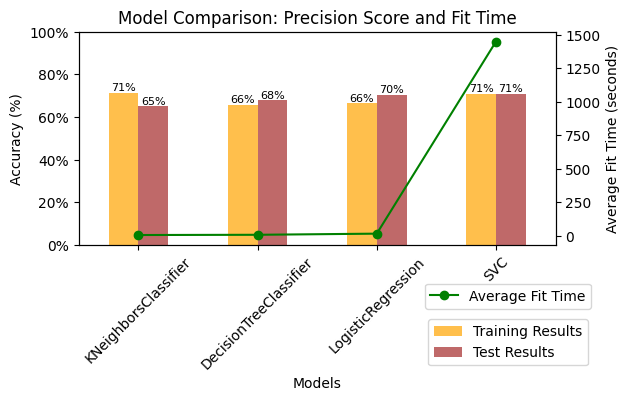

In [85]:
# Plotting
plt.figure(figsize=(10, 8))

# Create a bar plot for Train and Test Accuracy
bar_plot = accuracy_results_df.plot(kind='bar', color=['orange', 'brown'], alpha=0.7)

# Set title and labels
plt.title('Model Comparison: Precision Score and Fit Time')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')

# Convert y-axis to percentage
plt.yticks(ticks=[i/100 for i in range(0, 101, 20)], labels=[f'{i}%' for i in range(0, 101, 20)])

plt.xticks(rotation=45)

# Place the legend at the bottom
plt.legend(loc='lower center', bbox_to_anchor=(0.9, -0.6), ncol=1)

# Add values on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(
        f'{p.get_height():.0%}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', 
        va='bottom', 
        fontsize=8, 
        color='black',
    )

# Create a second y-axis for 'average fit time'
ax2 = plt.gca().twinx()  # Get the current axis and create a twin axis

# Plot 'average fit time' on the second y-axis
ax2.plot(fit_time_results_df.index, fit_time_results_df['Mean Fit Time'], color='green', marker='o', label='Average Fit Time')

# Set the label for the second y-axis
ax2.set_ylabel('Average Fit Time (seconds)')

# Place the legend at the bottom
ax2.legend(loc='upper center', bbox_to_anchor=(0.9, -0.15))

# Show the plot
plt.tight_layout()

plt.savefig('images/Hyperparameter_Model_Tuning_Results.png')
plt.show();

**Summary of Tuning**

- We see that **LogReg** and **SVC** models have the best test results after GridSearch.
- We have seen precision scores here and tuned for that.
- We will next explore the ROC AUC metric, by running the model again and training it using the best parameters obtained in the GridSearch. 

In [87]:
tuning_results_df.loc['SVC']['Best Parameters']

{'classifier__C': 1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}

In [89]:
best_params = tuning_results_df.loc['SVC']['Best Parameters']
svc_model = SVC(
    kernel = best_params['classifier__kernel'],
    C = best_params['classifier__C'],
    gamma = best_params['classifier__gamma'],
)

In [91]:
prod_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', svc_model),
    ]
)

In [93]:
prod_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('classifier', SVC(C=1, gamma='auto'))])

In [96]:
y_train_pred = prod_pipeline.predict(X_train)
y_test_pred = prod_pipeline.predict(X_test)

In [99]:
print(f'Precision Score for TRAINING set is: {precision_score(y_train, prod_pipeline.predict(X_train)):.2%}')

Precision Score for training set is: 71.02%


In [101]:
print(f'Precision Score for TEST set is: {precision_score(y_test, prod_pipeline.predict(X_test)):.2%}')

Precision Score for TEST set is: 71.02%


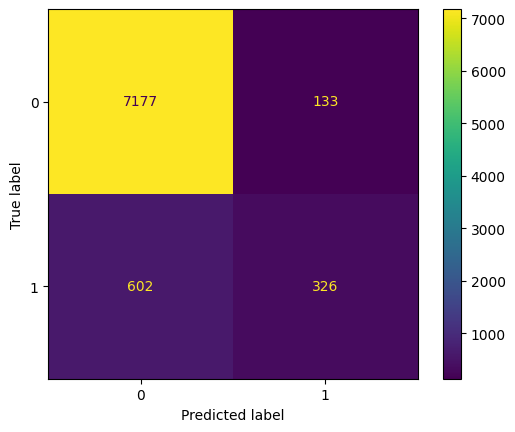

In [103]:
ConfusionMatrixDisplay.from_estimator(prod_pipeline, X_test, y_test)

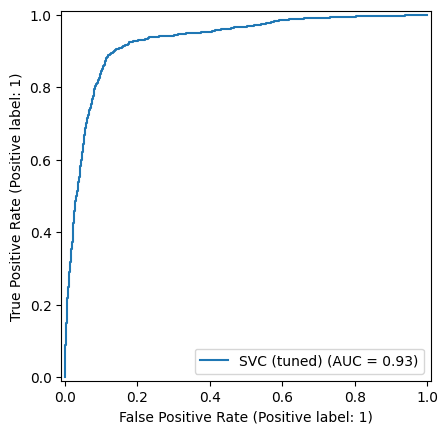

In [105]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(prod_pipeline, X_test, y_test, name = 'SVC (tuned)')

In [107]:
best_params = tuning_results_df.loc['DecisionTreeClassifier']['Best Parameters']
dtree_model = DecisionTreeClassifier(
    max_depth = best_params['classifier__max_depth'],
    min_samples_leaf = best_params['classifier__min_samples_leaf'],
    min_samples_split = best_params['classifier__min_samples_split'],
)

In [109]:
dtree_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', dtree_model),
    ]
)

In [111]:
dtree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=4))])

In [113]:
y_train_pred = dtree_pipeline.predict(X_train)
y_test_pred = dtree_pipeline.predict(X_test)

In [115]:
precision_score(y_train, y_train_pred)

0.6562603786117569

In [117]:
precision_score(y_test, y_test_pred)

0.677731673582296

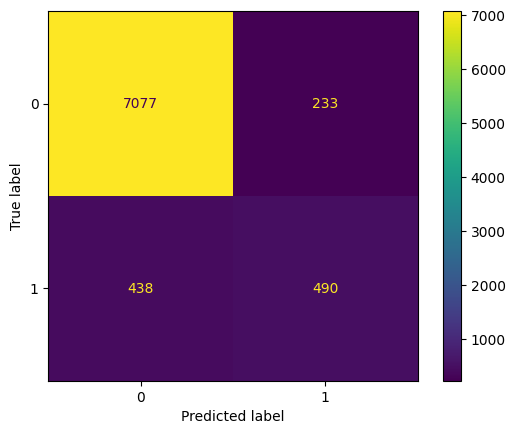

In [119]:
ConfusionMatrixDisplay.from_estimator(dtree_pipeline, X_test, y_test)

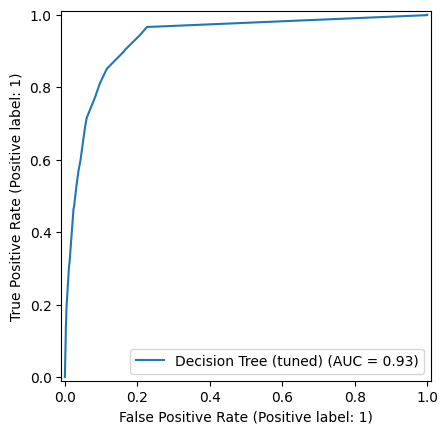

In [121]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(dtree_pipeline, X_test, y_test, name = 'Decision Tree (tuned)')

### Influence of credit default on contact result

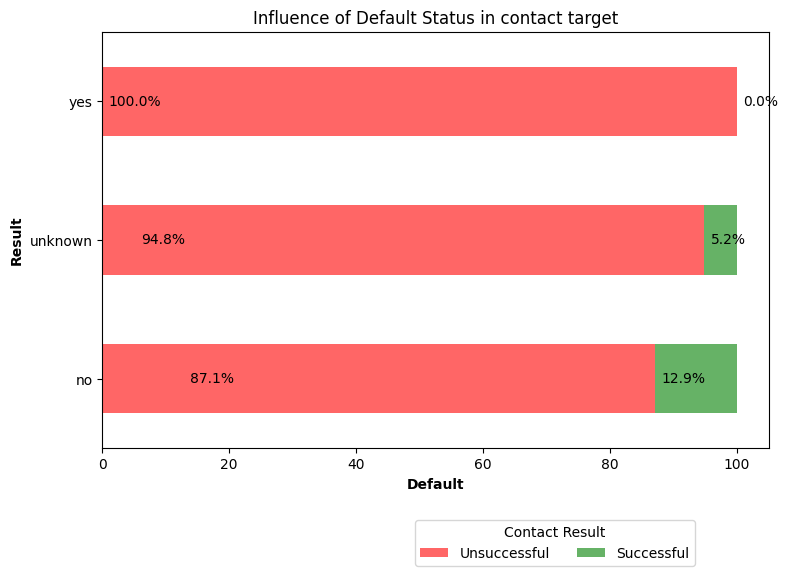

In [125]:
# Calculate the counts of each class for the 'default' categories
count_data = df.groupby(['default', 'y']).size().unstack(fill_value=0)

# Ensure the order of the classes is consistent
count_data = count_data.reindex(columns=['no', 'yes'], fill_value=0)

# Calculate percentages
percentage_data = count_data.div(count_data.sum(axis=1), axis=0) * 100

# Plotting as a horizontal bar chart
percentage_data.plot(
    kind='barh', 
    stacked=True, 
    figsize=(8, 6),  
    color=['red', 'green'],
    alpha = 0.6,
)

# Adding labels and title
plt.title('Influence of Default Status in contact target')
plt.xlabel('Default', fontweight='bold')
plt.ylabel('Result', fontweight='bold')

# Move the legend close to the y-axis label
plt.legend(title='Contact Result', labels=['Unsuccessful', 'Successful'], loc='lower right', bbox_to_anchor=(0.9, -0.3), ncol = 2)

# Adding percentage labels on top of the bars
for i in range(len(percentage_data)):
    for j in range(len(percentage_data.columns)):
        plt.text(
            percentage_data.iloc[i, j] + 1, i, 
            f"{100 - percentage_data.iloc[i, j]:.1f}%", 
            # ha = 'right', 
            va='center',
        )

plt.tight_layout()  # Adjust layout to make room for the legend
plt.savefig('images/default_effect_on_contact.png')
plt.show()

Those who are not in default (Result = 'no') seem to mirror the distribution of the whole dataset, while those whose credit status is 'Unknown' are less than half as likely to be successful in landing deposit after contact. This information can possibly be used in further tuning. 